# Actividad 2: Convolutional Neural Networks


**Autores de la actividad**

*   Javier Fernández Lasso
*   Fernando Palomino Cobo
*   Carles Serra Vendrell
*   Monica Hazeu Gonzalez



En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## 1) Carga de los datos y librerías

In [ ]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import random
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix
import itertools
np.random.seed(2)


# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10665984/10658925 [==============================] - 1s 0us/step


In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [ ]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## 2) Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

Normalizar las imágenes:

In [ ]:
X=X / 255.0
X_t=X_t / 255.0

In [ ]:
print(f'Hay {X.shape[0]} imágenes de training, de tamaño {X.shape[1]} x {X.shape[2]}')
print(f'Hay {X_t.shape[0]} imágenes de testing, de tamaño {X_t.shape[1]} x {X_t.shape[2]}')

Hay 18992 imágenes de training, de tamaño 64 x 64
Hay 890 imágenes de testing, de tamaño 64 x 64


Creamos una función para mostrar una muestra aleatoria de las imágenes:

In [ ]:
def display_samples(samples_index,imgs,obs, preds_classes=None,preds=None):
    '''Función para mostrar una muestra aleatoria de imágenes
    
    Parámetros
    ---------
    samples_index
    imgs
    obs
    preds_classes
    preds
    '''
    n = 0
    nrows = 3
    ncols = 6
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_index[n]
            ax[row,col].imshow(imgs[index, :, :, ::-1]) #change bgr to rgb
            
            actual_label = MAP_CHARACTERS[obs[index]].split("_")[0]
            actual_text = "Actual : {}".format(actual_label)
            
            ax[row,col].add_patch(patches.Rectangle((0, 53),64,25,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("fantasy")
            
            ax[row,col].text(1, 54, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')
            n += 1

In [ ]:
def pick_up_random_element(elem_type,array):
    return int(random.choice(np.argwhere(array == elem_type)))

Mostramos algunas imágenes con su _ground truth_:

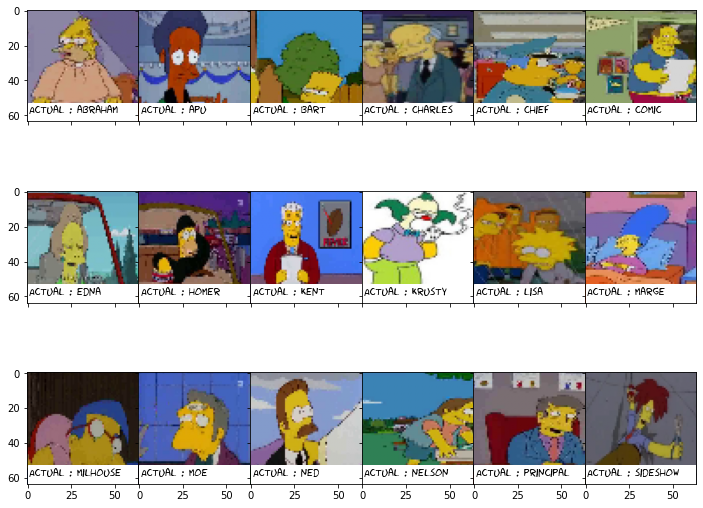

In [ ]:
samples = [pick_up_random_element(elem_type,y) for elem_type in range(18)]

display_samples(samples,X,y)

In [ ]:
y = to_categorical(y, num_classes = 18)
y_t = to_categorical(y_t, num_classes = 18)

Se van a entrenar varios modelos para intentar alcanzar la precisión objetivo. Se utilizarán las siguientes funciones de la actividad 1 para graficar _accuracy_ y _loss_:

In [ ]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

### 2.1) Primer modelo de prueba:
Para el primer modelo, vamos a usar una red neuronal fully-connected. Sabemos de antemano que va a ser computacionalmente complicado, ya que vamos a aumentar el tamaño de las imágenes y por tanto el número de parámetros va a ser muy elevado. Por ello, vamos a hacer una red sencilla para que se pueda compilar. 



In [ ]:
model= keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[64,64,3]))
model.add(keras.layers.Dense(512, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(18, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 512)               6291968   
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)             

In [ ]:
optimizer = RMSprop(lr=0.001) #optimizador

In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"]) #compilar el modelo

In [ ]:
epochs = 50
batch_size = 64
    
#entrenar
history = model.fit(X, y, 
                    batch_size=batch_size, 
                    shuffle=True,
                    epochs = epochs, 
                    validation_split = 0.2)

Epoch 1/50
238/238 [==============================] - 3s 9ms/step - loss: 3.8284 - accuracy: 0.0795 - val_loss: 2.7381 - val_accuracy: 0.1324
Epoch 2/50
238/238 [==============================] - 2s 7ms/step - loss: 2.7364 - accuracy: 0.1399 - val_loss: 2.4700 - val_accuracy: 0.2253
Epoch 3/50
238/238 [==============================] - 2s 7ms/step - loss: 2.5282 - accuracy: 0.2070 - val_loss: 2.3516 - val_accuracy: 0.2748
Epoch 4/50
238/238 [==============================] - 2s 7ms/step - loss: 2.4126 - accuracy: 0.2492 - val_loss: 2.5461 - val_accuracy: 0.1914
Epoch 5/50
238/238 [==============================] - 2s 7ms/step - loss: 2.3333 - accuracy: 0.2768 - val_loss: 2.1647 - val_accuracy: 0.3577
Epoch 6/50
238/238 [==============================] - 2s 7ms/step - loss: 2.2603 - accuracy: 0.3069 - val_loss: 2.2642 - val_accuracy: 0.3067
Epoch 7/50
238/238 [==============================] - 2s 7ms/step - loss: 2.2230 - accuracy: 0.3162 - val_loss: 2.1095 - val_accuracy: 0.3348
Epoch 

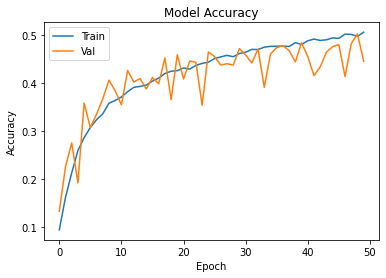

In [ ]:
plot_acc(history)

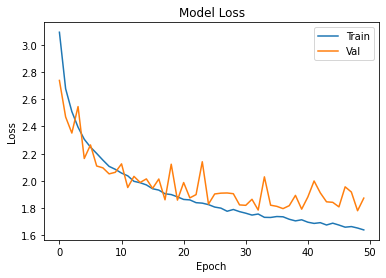

In [ ]:
plot_loss(history)

In [ ]:
loss, acc = model.evaluate(X_t,y_t,verbose = 0)

print("loss {:.5f} y accuracy {:.2f}%".format(loss,acc*100))

loss 1.62626 y accuracy 50.56%


Con fully-connected, no hemos probado añadiendo muchas capas porque si no el tiempo de cómputo sería muy elevado. Aún así, siendo el modelo lo más sencillo posible, ya de por si el tiempo de cómputo es es elevado ya que el número de parámetros a entrenar es de mas de 6 millones. Con este apartado, lo que se pretende demostrar, es que las capas fully-connected no son adecuadas para cierto tipo de problemas, como es este. Se ha obtenido una precisión del 50%. Es decir, los resultados que se obtienen son totalmente aleatorios. Vamos a probar en los siguientes apartados con capas convolucionales, que sí darán mejores resultados. 

### 2.2) Segundo modelo de prueba:
Como primer modelo de CNN, se va a probar una arquitectura muy sencilla, con dos convoluciones con _max pooling_ y dos capas _fully connected_. Como función de activación se elige ReLU.
La arquitectura es la siguiente:
* Convolución 2D, 32 filtros de 3x3, padding para preservar las dimensiones
* RELU
* _Max Pool_, 2x2, stride (2, 2)

* Convolución 2D, 64 filtros de 3x3, padding para preservar las dimensiones
* RELU
* _Max Pool_, 2x2, stride (2, 2)

* _Flatten_
* _Fully connected_, 512 neuronas
* RELU
* _Fully connected_, 18 neuronas
* Softmax

El uso de softmax permite interpretar los valores de salidas como probabilidades.

Se utiliza RMSprop como optimizador.

In [ ]:
#arquitectura del modelo
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(18, activation = "softmax"))

model.summary()

In [ ]:
optimizer = RMSprop(lr=0.001) #optimizador

In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"]) #compilar el modelo

In [ ]:
epochs = 10 
batch_size = 32
    
#entrenar
history = model.fit(X, y, 
                    batch_size=batch_size, 
                    shuffle=True,
                    epochs = epochs, 
                    validation_split = 0.2)

Epoch 1/10
475/475 [==============================] - 6s 10ms/step - loss: 2.1698 - accuracy: 0.3544 - val_loss: 1.1676 - val_accuracy: 0.6552
Epoch 2/10
475/475 [==============================] - 4s 9ms/step - loss: 0.9020 - accuracy: 0.7377 - val_loss: 0.9609 - val_accuracy: 0.7281
Epoch 3/10
475/475 [==============================] - 4s 9ms/step - loss: 0.4159 - accuracy: 0.8743 - val_loss: 1.0467 - val_accuracy: 0.7399
Epoch 4/10
475/475 [==============================] - 4s 9ms/step - loss: 0.1727 - accuracy: 0.9518 - val_loss: 1.0000 - val_accuracy: 0.7818
Epoch 5/10
475/475 [==============================] - 4s 9ms/step - loss: 0.0728 - accuracy: 0.9785 - val_loss: 1.2521 - val_accuracy: 0.7870
Epoch 6/10
475/475 [==============================] - 4s 9ms/step - loss: 0.0469 - accuracy: 0.9880 - val_loss: 1.4325 - val_accuracy: 0.7784
Epoch 7/10
475/475 [==============================] - 4s 9ms/step - loss: 0.0314 - accuracy: 0.9904 - val_loss: 1.5803 - val_accuracy: 0.7647
Epoch

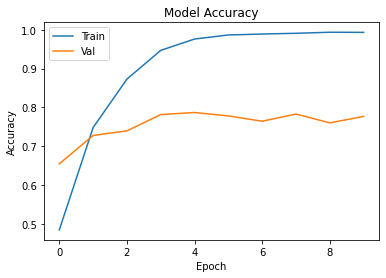

In [ ]:
plot_acc(history)

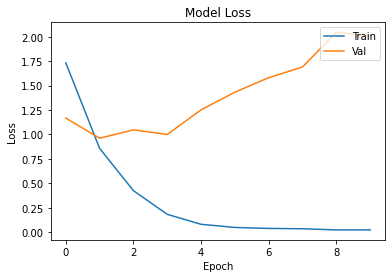

In [ ]:
plot_loss(history)

In [ ]:
loss, acc = model.evaluate(X_t,y_t,verbose = 0)

print("loss {:.5f} y accuracy {:.2f}%".format(loss,acc*100))

loss 0.48679 y accuracy 94.94%


Como se puede ver, el modelo claramente está cayendo en sobreajuste. Pese a que la precisión de _testing_ es muy alta, se puede ver en las gráficas de _loss_ y _accuracy_ que se debe a que los datos de _testing_ son más sencillos, viéndose que en el set de validación no se pasa del 77% de _accuracy_ versus el 99% en _training_.

### 2.3) Tercer modelo de prueba:
Intentando solventar el problema del sobreajuste del modelo anterior, se va a probar a añadir técnicas de regularización. En este modelo, se va a añadir _batch normalization_ y _dropout_, dos técnicas muy comunes de regularización.

La arquitectura es la siguiente:
* Convolución 2D, 32 filtros de 3x3, padding para preservar las dimensiones
* RELU
* _Max Pool_, 2x2, stride (2, 2)
* _Batch norm_ 
* _Dropout_ de 0.2

* Convolución 2D, 64 filtros de 3x3, padding para preservar las dimensiones
* RELU
* _Max Pool_, 2x2, stride (2, 2)
* _Batch norm_ 
* _Dropout_ de 0.2

* _Flatten_
* _Fully connected_, 512 neuronas
* RELU
* _Fully connected_, 18 neuronas
* Softmax

Se utiliza RMSprop como optimizador.

In [ ]:
#arquitectura del modelo
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(18, activation = "softmax"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 16, 64)       

In [ ]:
optimizer = RMSprop(lr=0.001) #optimizador

In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"]) #compilar el modelo

In [ ]:
epochs = 10 
batch_size = 32
    
#entrenar
history = model.fit(X, y, 
                    batch_size=batch_size, 
                    shuffle=True,
                    epochs = epochs, 
                    validation_split = 0.2)

Epoch 1/10
475/475 [==============================] - 6s 11ms/step - loss: 2.8744 - accuracy: 0.3897 - val_loss: 3.4405 - val_accuracy: 0.1956
Epoch 2/10
475/475 [==============================] - 5s 10ms/step - loss: 0.8774 - accuracy: 0.7398 - val_loss: 1.6397 - val_accuracy: 0.5657
Epoch 3/10
475/475 [==============================] - 5s 10ms/step - loss: 0.4526 - accuracy: 0.8630 - val_loss: 1.6043 - val_accuracy: 0.6339
Epoch 4/10
475/475 [==============================] - 5s 10ms/step - loss: 0.2630 - accuracy: 0.9226 - val_loss: 1.8350 - val_accuracy: 0.6312
Epoch 5/10
475/475 [==============================] - 5s 10ms/step - loss: 0.1875 - accuracy: 0.9425 - val_loss: 2.0024 - val_accuracy: 0.5894
Epoch 6/10
475/475 [==============================] - 5s 10ms/step - loss: 0.1347 - accuracy: 0.9590 - val_loss: 1.9737 - val_accuracy: 0.6412
Epoch 7/10
475/475 [==============================] - 5s 10ms/step - loss: 0.1235 - accuracy: 0.9665 - val_loss: 2.5513 - val_accuracy: 0.6196

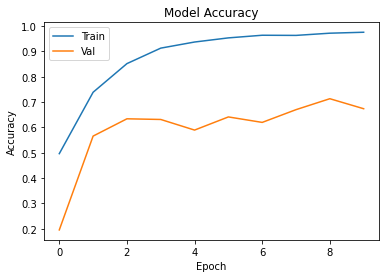

In [ ]:
plot_acc(history)

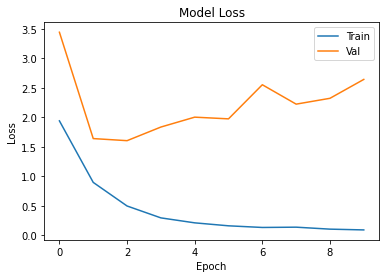

In [ ]:
plot_loss(history)

In [ ]:
loss, acc = model.evaluate(X_t,y_t,verbose = 0)

print("loss {:.5f} y accuracy {:.2f}%".format(loss,acc*100))

loss 1.06913 y accuracy 84.16%


Como se puede ver, todavía se observan señales de sobreajuste y el modelo no está aprendiendo correctamente. De hecho, la precisión en _testing_ ha bajado. Para intentar obtener mejores resultados, se va a completar más el modelo en el siguiente apartado.

### 2.4) Cuarto modelo de prueba:
En busca de obtener unos mejores resultados, se decide añadir capas a la arquitectura. Tras realizar distintas pruebas, se define la siguiente arquitectura.

* Convolución 2D, 32 filtros de 3x3, padding para preservar las dimensiones
* RELU
* Convolución 2D, 32 filtros de 3x3, padding para preservar las dimensiones
* RELU
* _Max Pool_, 2x2, stride (2, 2)
* _Batch norm_ 
* _Dropout_ de 0.25

* Convolución 2D, 64 filtros de 3x3, padding para preservar las dimensiones
* RELU
* Convolución 2D, 64 filtros de 3x3, padding para preservar las dimensiones
* RELU
* _Max Pool_, 2x2, stride (2, 2)
* _Batch norm_ 
* _Dropout_ de 0.25

* Convolución 2D, 86 filtros de 3x3, padding para preservar las dimensiones
* RELU
* Convolución 2D, 86 filtros de 3x3, padding para preservar las dimensiones
* RELU
* _Max Pool_, 2x2, stride (2, 2)
* _Batch norm_ 
* _Dropout_ de 0.25

* _Flatten_
* _Fully connected_, 512 neuronas
* RELU
* _Dropout_ de 0.5
* _Fully connected_, 18 neuronas
* Softmax

Se utiliza RMSprop como optimizador. Adicionalmente, se ha añadido _learning rate decay_. Se ha observado que el aprendizaje sin _decay_ sobreajusta al rededor de la epoch 16, mientras que al añadir el _decay_ se ha conseguido evitar este sobreajuste.

In [ ]:
#arquitectura del modelo
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(18, activation = "softmax"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)       

In [ ]:
optimizer = RMSprop(lr=0.001, decay=1e-6) #optimizador

In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"]) #compilar el modelo

In [ ]:
epochs = 20 
batch_size = 32
    
#entrenar
history = model.fit(X, y, 
                    batch_size=batch_size, 
                    shuffle=True,
                    epochs = epochs, 
                    validation_split = 0.2)

Epoch 1/20
475/475 [==============================] - 41s 16ms/step - loss: 2.8996 - accuracy: 0.2759 - val_loss: 1.9547 - val_accuracy: 0.3906
Epoch 2/20
475/475 [==============================] - 7s 14ms/step - loss: 1.5009 - accuracy: 0.5641 - val_loss: 1.6510 - val_accuracy: 0.6196
Epoch 3/20
475/475 [==============================] - 7s 14ms/step - loss: 1.1511 - accuracy: 0.6687 - val_loss: 1.0124 - val_accuracy: 0.7115
Epoch 4/20
475/475 [==============================] - 7s 14ms/step - loss: 0.9248 - accuracy: 0.7338 - val_loss: 1.5013 - val_accuracy: 0.6510
Epoch 5/20
475/475 [==============================] - 7s 14ms/step - loss: 0.8068 - accuracy: 0.7737 - val_loss: 1.2796 - val_accuracy: 0.7905
Epoch 6/20
475/475 [==============================] - 7s 14ms/step - loss: 0.7526 - accuracy: 0.7910 - val_loss: 1.0122 - val_accuracy: 0.7515
Epoch 7/20
475/475 [==============================] - 7s 14ms/step - loss: 0.6886 - accuracy: 0.8100 - val_loss: 0.7946 - val_accuracy: 0.800

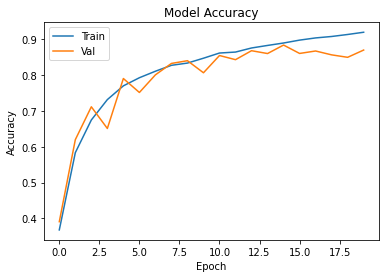

In [ ]:
plot_acc(history)

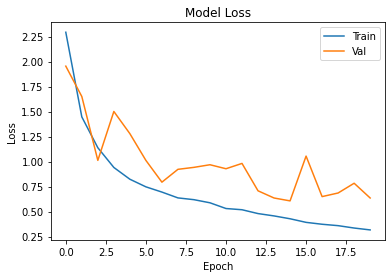

In [ ]:
plot_loss(history)

In [ ]:
loss, acc = model.evaluate(X,y,verbose = 0)
loss_t, acc_t = model.evaluate(X_t,y_t,verbose = 0)

print("loss {:.5f} y accuracy {:.2f}%".format(loss,acc*100))
print("loss {:.5f} y accuracy {:.2f}%".format(loss_t,acc_t*100))

loss 0.19932 y accuracy 95.16%
loss 0.20289 y accuracy 94.04%


Como se puede ver, gracias al _decay_ se está consiguiendo evitar que el modelo sobreajuste. Se ha comprobado que es esto lo que habilita evitar el sobreajuste, puesto que se ha entrenado la misma arquitectura con el mismo _learning rate_ inicial, obteniendo resultados mucho mejores gracias al _decay_ (84% de precisión en _testing_ sin _decay_ versus 95% con _decay_).

### 2.5) Quinto modelo de prueba:
Se ha intentado reducir el número de parámetros de la red, para evitar que exista un sobreajuste como en los modelos anteriores. También, se ha reducido el espacio de caracteríticas aún más que en los modelos anteriores.
Además, se ha utilizado la función de activiación LeakyReLU, para comprobar si se soluciona un posible problema de neuronas muertas a causa de la ReLU.

Se continua utilizado RMSprop como optimizador con *learning rate decay*. Y el tiempo de entrenamiento ha aumentado a 60 *epochs*

In [ ]:
model = Sequential()

#  Se añaden las capas al modelo

#  Bloque 1 CNN
model.add(Conv2D(32, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True,
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

#  Bloque 2 CNN
model.add(Conv2D(64, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

# Bloque 3 CNN
model.add(Conv2D(64, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

# Bloque 4 CNN
model.add(Conv2D(128, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Bloque 5 CNN
model.add(Conv2D(254, (3, 3),
                        activation=keras.layers.LeakyReLU(alpha=0.3),
                        padding='same',
                        use_bias=True))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

#  Bloque 6 FC
model.add(Flatten())
model.add(Dense(254, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(128, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(18, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_19 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)       

In [ ]:
optimizer = RMSprop(lr=0.001, decay=1e-6) #optimizador

In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"]) #compilar el modelo

In [ ]:
epochs = 60 
batch_size = 64
    
#entrenar
history = model.fit(X, y, 
                    batch_size=batch_size, 
                    shuffle=True,
                    epochs = epochs, 
                    validation_split = 0.2)

Epoch 1/60
238/238 [==============================] - 6s 19ms/step - loss: 5.0614 - accuracy: 0.0993 - val_loss: 2.7404 - val_accuracy: 0.0956
Epoch 2/60
238/238 [==============================] - 4s 18ms/step - loss: 2.7187 - accuracy: 0.2187 - val_loss: 2.0970 - val_accuracy: 0.3656
Epoch 3/60
238/238 [==============================] - 4s 18ms/step - loss: 2.1569 - accuracy: 0.3520 - val_loss: 1.6502 - val_accuracy: 0.4814
Epoch 4/60
238/238 [==============================] - 4s 18ms/step - loss: 1.7733 - accuracy: 0.4604 - val_loss: 1.1614 - val_accuracy: 0.6573
Epoch 5/60
238/238 [==============================] - 4s 18ms/step - loss: 1.4901 - accuracy: 0.5528 - val_loss: 2.2275 - val_accuracy: 0.4714
Epoch 6/60
238/238 [==============================] - 4s 18ms/step - loss: 1.3125 - accuracy: 0.5985 - val_loss: 0.9360 - val_accuracy: 0.7194
Epoch 7/60
238/238 [==============================] - 4s 18ms/step - loss: 1.1738 - accuracy: 0.6433 - val_loss: 0.8919 - val_accuracy: 0.7373

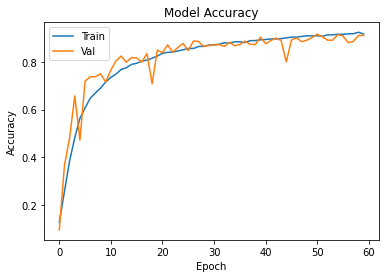

In [ ]:
plot_acc(history)

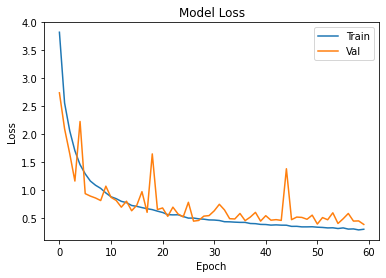

In [ ]:
plot_loss(history)

In [ ]:
loss, acc = model.evaluate(X,y,verbose = 0)
loss_t, acc_t = model.evaluate(X_t,y_t,verbose = 0)

print("loss {:.5f} y accuracy {:.2f}%".format(loss,acc*100))
print("loss {:.5f} y accuracy {:.2f}%".format(loss_t,acc_t*100))

loss 0.12591 y accuracy 97.09%
loss 0.14014 y accuracy 96.18%


Destacar que este modelo funciona muy bien, obteniedo un 96% de precisión en los datos de test. Añadir que se ha entrenado durante más epochs en comparación a los demás modelos, ya que no se tiene sobreajuste como en los anteriores.
Añadir que se ha probado a utilizar *data augmentation* con este modelo, pero los resultados son muy malos, ya que es una tarea muy compleja para el tamaño del modelo y por tanto, los resultados del entrenamiento son muy malos.

## 3) Modelo final y evaluación de resultados:
La arquitectura del modelo 5 es muy adecuada, como se ha podido observar, por lo que se va a mantener como arquitectura final. 
Sin embargo, se va a probar a utilizar _data augmentation_ en el modelo 4 (ya que este tiene más parámetros y presenta un ligero sobre ajuste) para comprobar si esto tiene beneficios sobre el entrenamiento y el modelo final consige generalizar más ante datos .

### 3.1) Modelo final con _data augmentation_

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(18, activation = "softmax"))

In [ ]:
optimizer = RMSprop(lr=0.001, decay=1e-6)

In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

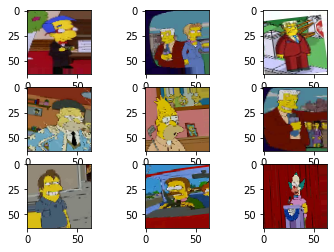

In [ ]:
#Data augmentation
    
datagen = ImageDataGenerator(
    featurewise_center=False,  # establecer la media de entrada en 0 sobre el conjunto de datos
    samplewise_center=False,  # establecer la media de cada muestra en 0
    featurewise_std_normalization=False,  # dividir las entradas por la norma del conjunto de datos
    samplewise_std_normalization=False,  # dividir cada entrada por su std
    zca_whitening=False,  # aplicar el blanqueamiento ZCA
    rotation_range=10,  # girar aleatoriamente las imágenes en el rango (grados, 0 a 180)
    zoom_range = 0.1, # Ampliar la imagen aleatoriamente 
    width_shift_range=0.1,  # desplazar aleatoriamente las imágenes en sentido horizontal (fracción del ancho total)
    height_shift_range=0.1,  # desplazar aleatoriamente las imágenes en sentido vertical (fracción de la altura total)
    horizontal_flip=True,  # voltear imágenes al azar horizontalmente
    vertical_flip=False)  # voltear imágenes al azar verticalmente
    
datagen.fit(X)

for x_batch, y_batch in datagen.flow(X, y, batch_size=9):
    for i in range(0, x_batch.shape[0]):
        plt.subplot(330 + 1 + i)
        plt.imshow((x_batch[i])[:, :, ::-1])
    plt.show()
    break

In [ ]:
epochs = 60 
batch_size = 32
    
history = model.fit_generator(datagen.flow(X,y, batch_size=batch_size, shuffle=True),
                              epochs = epochs, 
                              validation_data = (X,y),
                              steps_per_epoch=X.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
593/593 [==============================] - 60s 45ms/step - loss: 2.9013 - accuracy: 0.2519 - val_loss: 1.7465 - val_accuracy: 0.4583
Epoch 2/60
593/593 [==============================] - 25s 42ms/step - loss: 1.6701 - accuracy: 0.5101 - val_loss: 1.4251 - val_accuracy: 0.6037
Epoch 3/60
593/593 [==============================] - 25s 42ms/step - loss: 1.3369 - accuracy: 0.6192 - val_loss: 1.0207 - val_accuracy: 0.7268
Epoch 4/60
593/593 [==============================] - 25s 43ms/step - loss: 1.1668 - accuracy: 0.6671 - val_loss: 0.9717 - val_accuracy: 0.7468
Epoch 5/60
593/593 [==============================] - 25s 42ms/step - loss: 1.1106 - accuracy: 0.6918 - val_loss: 1.4868 - val_accuracy: 0.7051
Epoch 6/60
593/593 [==============================] - 25s 42ms/step - loss: 1.0393 - accuracy: 0.7229 - val_loss: 1.1973 - val_accuracy: 0.7828
Epoch 7/60
593/593 [==============================] - 25s 42ms/step - loss: 1.0150 - accuracy: 0.7368 - val_loss: 0.8201 - val_accuracy:

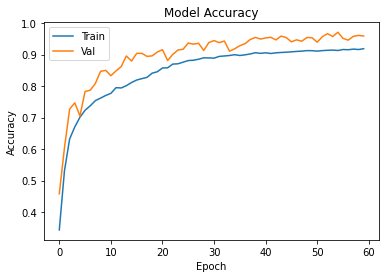

In [ ]:
plot_acc(history)

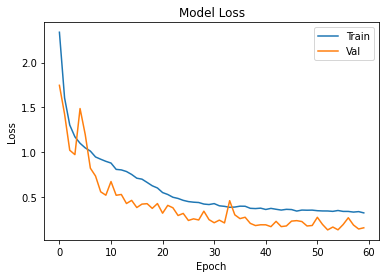

In [ ]:
plot_loss(history)

In [ ]:
loss, acc = model.evaluate(X,y,verbose = 0)
loss_t, acc_t = model.evaluate(X_t,y_t,verbose = 0)

print("Training: loss {:.5f} y accuracy {:.2f}%".format(loss,acc*100))
print("Testing: loss {:.5f} y accuracy {:.2f}%".format(loss_t,acc_t*100))

Training: loss 0.15351 y accuracy 95.87%
Testing: loss 0.17568 y accuracy 93.71%


Como se puede observar, los resultados con _data augmentation_ y sin ella son comparables, viéndose que en la epoch 20 se tienen precisiones parecidas. Sin embargo, es posible que el modelo entrenado sea más capaz de generalizar frente a nuevos datos, sobre todo datos que no sean tan sencillos como los que se tiene en este set de _testing_. Es por ello que la práctica de _data augmentation_ es adecuada siempre y cuando queramos que nuestro modelo sea lo más general posible.

### 3.2) Evaluación de las clases
A continuación se va a evaluar cuáles son las clases donde se encuentran mayores errores y confusiones entre ellas. Para ello, se utilizará la matriz de confusión.

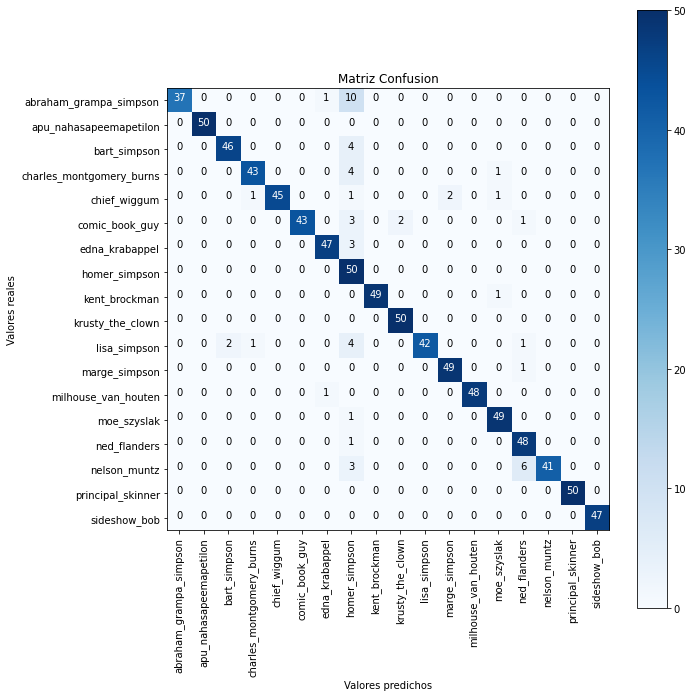

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz Confusion',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valores reales')
    plt.xlabel('Valores predichos')
    

# Predecir los valores del conjunto de datos de validación
Y_pred = model.predict(X_t)
# Convertir los resultados de la predicción de los vectores mas altos en una lista de clases
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convertir las observaciones de validación de los vectores mas altos en una lista de clases
Y_true = np.argmax(y_t,axis = 1) 
# calcular la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# imprimir por pantalla la matriz de confusión
plot_confusion_matrix(confusion_mtx, classes = list(MAP_CHARACTERS.values())) 

Como se puede ver, las dos clases que la red confunde más son Abraham Simpson y Homer Simpson. Es curioso que suceda esto porque son padre e hijo, y lo más posible es que el modelo los confunda por la parte de la cabeza sin pelo, ojos, nariz y barba, muy similar en ambos personajes. Hay alguna confusión adicional entre otros personajes, pero no es muy significativo ya que son pocas imágenes las que están mal clasificadas.

A continuación, se muestran algunas de las predicciones realizadas.

In [ ]:
def display_samples_pred(samples_index,imgs,obs, preds_classes=None,preds=None):
  
    n = 0
    nrows = 3
    ncols = 6
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_index[n]
            ax[row,col].imshow(imgs[index,:,:,::-1])
            
            actual_label = MAP_CHARACTERS[obs[index]].split("_")[0]
            actual_text = "Actual : {}".format(actual_label)
            
            ax[row,col].add_patch(patches.Rectangle((0, 53),64,25,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("fantasy")
            
            ax[row,col].text(1, 54, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')
            
            if preds_classes.any() != None and preds.any() != None:
                predicted_label = MAP_CHARACTERS[preds_classes[index]].split('_')[0]
                predicted_proba = max(preds[index])*100
                predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
                ax[row,col].text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')
            n += 1

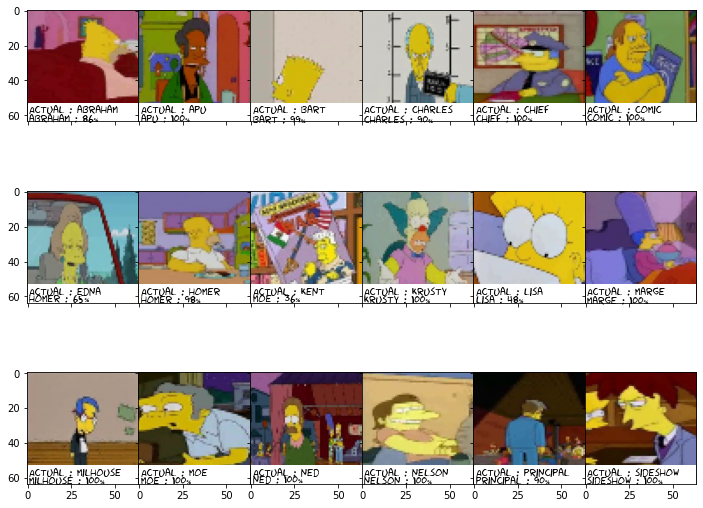

In [ ]:
samples = [pick_up_random_element(elem_type,Y_true) for elem_type in range(18)]
display_samples_pred(samples, X_t, Y_true, Y_pred_classes,Y_pred)

Como se puede observar, las imágenes predichas correctamente tienen una certeza superior al 95%. Por otro lado, las imágenes incorrectas tienen una precisión muy baja, a excepción de la confusión entre Homer y su padre, que aún así sigue siendo inferior al 80%. Esto es bueno, puesto que implica que un filtro de 90% de certeza permitiría obtener predicciones correctas, pudiendo enviar las imágenes con certeza inferior a esta a evaluación, ya que seguramente sean incorrectas.

## 4) Referencias



*   **Data Generation** https://torres.ai/data-augmentation-y-transfer-learning-en-keras-tensorflow/
*   **Max pooling** https://www.aprendemachinelearning.com/clasificacion-de-imagenes-en-python/

